# Summary

Experiments with deriving metric tensors (in $\mathsf{T}\mathsf{M}$ and $\mathsf{T}^{*\!}\mathsf{M}$), Cartan torsion, the Christoffel coefficients (tensor), and the geodesic equation (plus spray coefficients).

### Preliminaries

In [1]:
import sympy as sy, numpy as np, os
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, trigsimp, expand, factor, powsimp, \
    Eq, solve, solveset, sqrt, diff, Matrix, det, tan, cos, sin, sec, csc, \
    Abs, Rational, pi, re, im, atan, atan2, numer, denom, \
    lambdify, log, collect, cancel, integrate, Integral, \
    nroots, poly, N

from gmplib.utils import e2d
from gmplib.plot_utils import GraphingBase

from gme.core.symbols import *
from gme.core.equations import Equations

from functools import reduce

from scipy.optimize import root_scalar
from scipy.linalg import norm

In [2]:
# from notebook.services.config import ConfigManager
# cm = ConfigManager().update('notebook', {'limit_output': 20000})

# Basics

In [3]:
gmeq = Equations( eta_=Rational(1,2),  mu_=Rational(1,4),
                  beta_type='sin', do_raw=True )

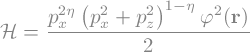

In [4]:
H_ = gmeq.H_eqn.rhs
gmeq.H_eqn

In [5]:
gmeq.varphi_rx_eqn

In [6]:
H1_ = H_.subs({varphi_r(rvec):1})
# Assume indexing here ranges in [1,2]
p_i_lambda = lambda i: [px, pz][i-1]
r_i_lambda = lambda i: [rx, rz][i-1]
rdot_i_lambda = lambda i: [rdotx, rdotz][i-1]

# Co-Finsler metric tensor  ${g}^{ij}$

### From  Hamilton's equations

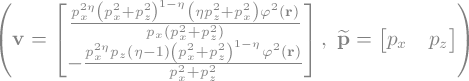

In [7]:
gmeq.rdot_vec_eqn, gmeq.p_covec_eqn

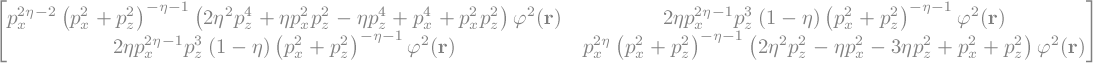

In [8]:
gstar_raw = simplify( Matrix([diff(gmeq.rdot_vec_eqn.rhs, gmeq.p_covec_eqn.rhs[0]).T,
                              diff(gmeq.rdot_vec_eqn.rhs, gmeq.p_covec_eqn.rhs[1]).T]) )
gstar_raw

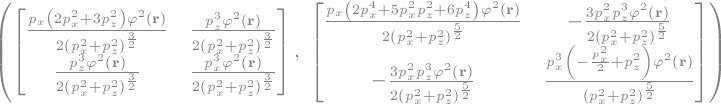

In [9]:
simplify( gstar_raw.subs({eta:Rational(1,2)}) ), simplify( gstar_raw.subs({eta:Rational(3,2)}) )

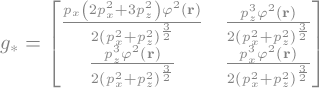

In [10]:
simplify( gmeq.gstar_varphi_pxpz_eqn  )

### From $H(\vec{r},\mathbf{p})$

In [11]:
p_i_lambda(2)

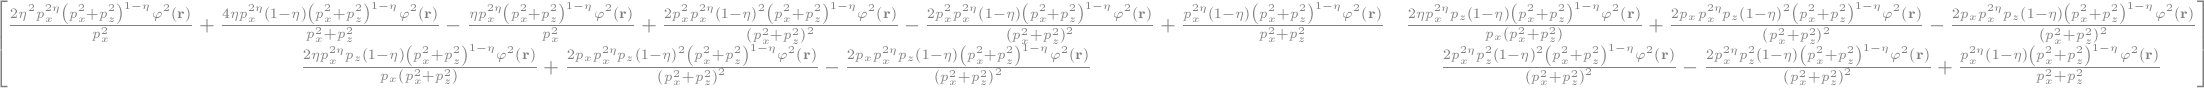

In [12]:
gstar_ij_lambda = lambda i_,j_: ( Rational(2,2)*diff(diff(H_,p_i_lambda(i_)),p_i_lambda(j_)) )
gstar_mat = Matrix([[gstar_ij_lambda(1,1),gstar_ij_lambda(2,1)],
                    [gstar_ij_lambda(1,2),gstar_ij_lambda(2,2)]])
gstar_mat

In [13]:
# gstar1_ij_lambda = lambda i,j: gstar_ij_lambda(i,j)
# Matrix([[gstar1_ij_lambda(1,1), gstar1_ij_lambda(2,1)],
#         [gstar1_ij_lambda(1,2), gstar1_ij_lambda(2,2)]])

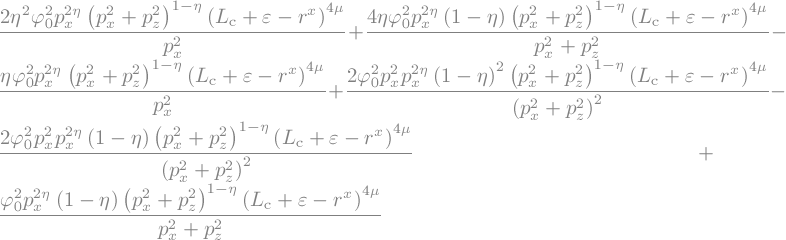

In [14]:
gstar_rx_ij_lambda \
    = lambda i,j: gstar_ij_lambda(i,j).subs({varphi_r(rvec):gmeq.varphi_rx_eqn.rhs})
gstar_rx_ij_lambda(1,1)

In [15]:
gstar_det = simplify(gstar_mat.det())
gstar_det

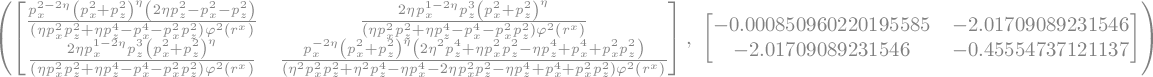

In [16]:
g_ij_pxpz_lambda = lambda i,j: simplify( 
    (gstar_ij_lambda(3-i,3-j)*(-1)**i*(-1)**j)/gstar_det ) \
        .subs({varphi_r(rvec):varphi_rx(rx)})
g_ij_pxpz_lambda_mat \
    = ( 
    Matrix([[g_ij_pxpz_lambda(1,1),g_ij_pxpz_lambda(2,1)],
            [g_ij_pxpz_lambda(1,2),g_ij_pxpz_lambda(2,2)]])
#                     .subs({eta:gmeq.eta})
#                     .subs({sqrt(px**2+pz**2):-sqrt(px**2+pz**2)})
      )
(g_ij_pxpz_lambda_mat, 
 g_ij_pxpz_lambda_mat.subs({varphi_rx(rx):1, px:0.075, pz:-1, eta:gmeq.eta_}))

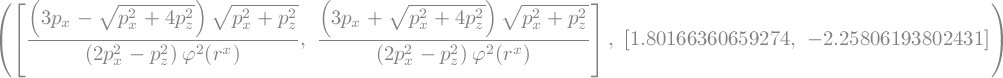

In [17]:
evcts = [factor(evct[0]) for evct in g_ij_pxpz_lambda_mat.subs({eta:gmeq.eta_}).eigenvects()]
evcts, [evct.subs({varphi_rx(rx):1, px:0.075, pz:-1}) for evct in evcts]

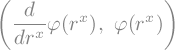

In [18]:
d_varphi_rx = Function(r'\varphi', real=True, positive=True)(rx)
diff(varphi_rx(rx),rx),d_varphi_rx

### Determinant

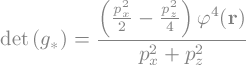

In [19]:
gmeq.det_gstar_varphi_pxpz_eqn

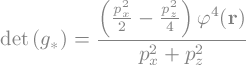

In [20]:
Eq(det_gstar,simplify(expand(gmeq.det_gstar_varphi_pxpz_eqn.rhs)
                      .subs(e2d(gmeq.tanbeta_pxpz_eqn, do_flip=True, do_negate=True))))

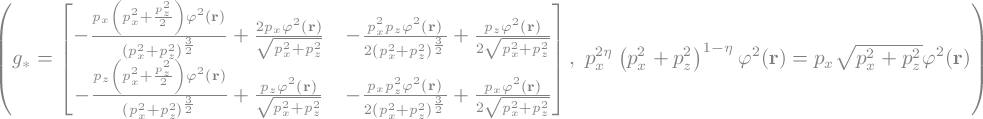

In [21]:
gstar_eqn = gmeq.gstar_varphi_pxpz_eqn
gstar_eqn, Eq( gmeq.Fstar_eqn.rhs**2, simplify(  gstar_eqn.rhs[0]*px*px 
                                               + gstar_eqn.rhs[1]*px*pz
                                               + gstar_eqn.rhs[2]*pz*px
                                               + gstar_eqn.rhs[3]*pz*pz ) )

# Metric tensor $g_{ij}$

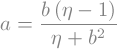

In [22]:
tab_eqn = gmeq.tanalpha_beta_eqn.subs({tan(alpha):ta, tan(beta):tb})
tab_eqn

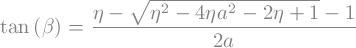

In [23]:
tanbeta_eqn = Eq(tan(beta), simplify( solve(tab_eqn, tb)[0] ))
tanbeta_eqn

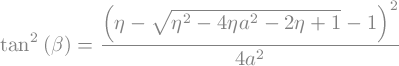

In [24]:
tan2beta_eqn = factor(Eq(tan(beta)**2,tanbeta_eqn.rhs**2))
tan2beta_eqn

In [25]:
gmeq.px_pz_tanbeta_eqn

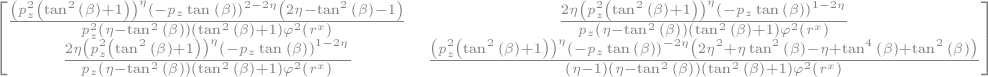

In [26]:
g_ij_tanbeta_lambda = lambda i,j: factor( g_ij_pxpz_lambda(i,j)
                                         .subs(e2d(gmeq.px_pz_tanbeta_eqn)) ) 
Matrix([
    [g_ij_tanbeta_lambda(1,1),g_ij_tanbeta_lambda(1,2)],
    [g_ij_tanbeta_lambda(2,1),g_ij_tanbeta_lambda(2,2)]
])

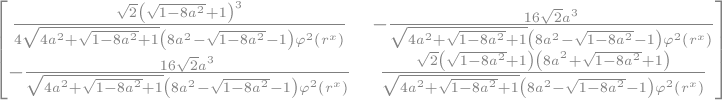

In [27]:
g_ij_ta_lambda = lambda i,j: factor( 
    g_ij_tanbeta_lambda(i,j)
    .subs({tanbeta_eqn.lhs:tanbeta_eqn.rhs, 
           tan2beta_eqn.lhs:tan2beta_eqn.rhs}).subs({eta:gmeq.eta_})
)

Matrix([
    [g_ij_ta_lambda(1,1),g_ij_ta_lambda(1,2)],
    [g_ij_ta_lambda(2,1),g_ij_ta_lambda(2,2)]
])

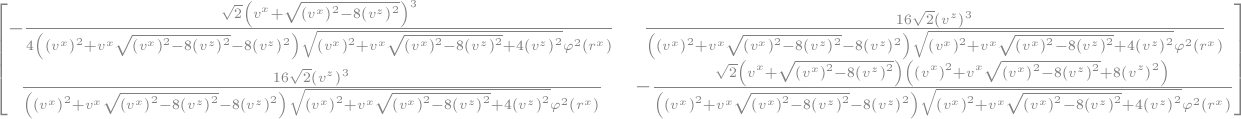

In [28]:
g_ij_rdotrx_lambda = lambda i,j: factor((g_ij_ta_lambda(i,j))
                                .subs({ta:tan(alpha)})
                                .subs(e2d(gmeq.tanalpha_rdot_eqn)) )
                                #.subs({gmeq.xi_rx_eqn.lhs:gmeq.xi_rx_eqn.rhs}))
Matrix([
    [g_ij_rdotrx_lambda(1,1),g_ij_rdotrx_lambda(1,2)],
    [g_ij_rdotrx_lambda(2,1),g_ij_rdotrx_lambda(2,2)]
])

# Cartan torsion

The Cartan torsion tensor is non-zero for Finsler spaces, so let's confirm by constructing the tensor and checking some coefficients.

In [29]:
C_ijk_lambda = lambda i_,j_,k_: ( 
    (Rational(1,2)*diff(g_ij_rdotrx_lambda(i_,j_),rdot_i_lambda(k_))
       .subs({varphi_rx(rx):1})))

Picking a random-ish velocity and a couple of symmetric 
coefficients, we see that they are non-zero:

In [30]:
( N( C_ijk_lambda(1,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  N( C_ijk_lambda(1,2,1).subs({rdotx:0.1,rdotz:0.01}) ) )

Checking the torsion symmetry further, switching the first index reveals antisymmetry in the respective components:

In [31]:
( sy.N( C_ijk_lambda(2,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  sy.N( C_ijk_lambda(2,2,1).subs({rdotx:0.1,rdotz:0.01}) ) )

In [32]:
# C_ijk_dict = {}
# for i in [1,2]:
#     for j in [1,2]:
#         for k in [1,2]:
#             C_ijk_ = Eq( symbols('C_{'+'{}{}{}'.format(i,j,k)+'}'),
#                          simplify(simplify(C_ijk_lambda(i,j,k).subs({cf:x}) )
#                                  .subs({Abs(rdotz):rdotz})) )
#             print(i,j,k)
#             C_ijk_dict.update({(i,j,k):C_ijk_})

In [33]:
# C_ijk = MatrixSymbol('C',1,8)
# C_ijk_raw = [(C_ijk_lambda(i_,j_,k_))
#              for i_ in [1,2] for j_ in [1,2] for k_ in [1,2]]
# C_ijk_eqn = Eq(C_ijk, Matrix(C_ijk_raw).T)


In [34]:
vC_ijk_raw = [(rdot_i_lambda(i_)*C_ijk_lambda(i_,j_,k_))
                       for i_ in [1,2] for j_ in [1,2] for k_ in [1,2]]
vC_ijk = (reduce(lambda a,b: a+b, vC_ijk_raw))
# vC_ijk

Picking a random-ish point in phase space, test to see if torsion applied to ray velocity is zero:

In [35]:
round(sy.N( vC_ijk.subs({rx:0.1,rdotx:0.9,rdotz:0.1}) ),15)

which it is within numerical precision.

# Christoffel tensor (aka Christoffel symbols)

In [36]:
gamma_i_jk_raw = lambda i_,j_,k_: [
    (Rational(1,2)*g_ij_rdotrx_lambda(i_,l_)*(
      diff(g_ij_rdotrx_lambda(l_,k_),r_i_lambda(j_)) 
    + diff(g_ij_rdotrx_lambda(j_,l_),r_i_lambda(k_))
    - diff(g_ij_rdotrx_lambda(j_,k_),r_i_lambda(l_)) ))
        .subs({Abs(rdotz):rdotz}).subs({eta:gmeq.eta_})
    for l_ in [1,2] ]
gamma_i_jk = lambda i_,j_,k_: factor( 
    reduce(lambda a,b: a+b, gamma_i_jk_raw(i_,j_,k_)   ) )

Check to see if symmetrically diagonal components are equal:

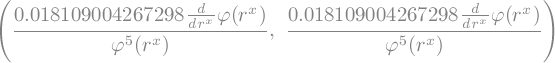

In [37]:
( sy.N( gamma_i_jk(1,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  sy.N( gamma_i_jk(1,2,1).subs({rdotx:1,rdotz:0.1}) ) )

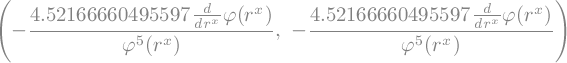

In [38]:
( sy.N( gamma_i_jk(2,1,2).subs({rdotx:1,rdotz:0.1}) ), 
  sy.N( gamma_i_jk(2,2,1).subs({rdotx:1,rdotz:0.1}) ) )

# Geodesic spray coefficients

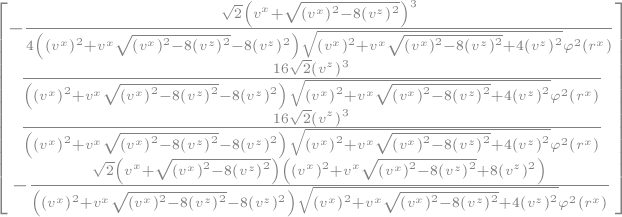

In [39]:
Matrix([g_ij_rdotrx_lambda(i_,j_) for j_ in [1,2] for i_ in [1,2]])

Below we are writing the spray coefficients ASSUMING our space is Berwald, which may not be (probably isn't) true!  i.e., the following may not be correct:

$
    G^i(x,v) = \tfrac{1}{2}\Gamma^i_{jk}(x)\, v^j v^k
$

The full expression, which doesn't assume a Berwald space, is:


$
    G^i(x,v) = \dfrac{1}{4} g^{im}\left( 
       2\dfrac{\partial g_{jm}}{\partial{x^k}}
      - \dfrac{\partial g_{jk}}{\partial{x^m}} \right) v^j v^k
$

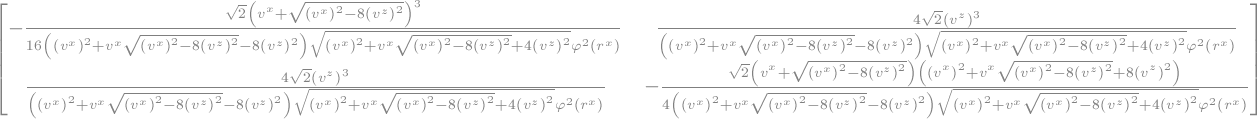

In [40]:
G_i_lambda_full_partg = lambda i_: [
    Rational(1,4)*g_ij_rdotrx_lambda(i_,m_)
    for m_ in [1,2] ]
Matrix([G_i_lambda_full_partg(1), G_i_lambda_full_partg(2)])

In [41]:
G_i_lambda_raw = lambda i_: [(Rational(1,2)*gamma_i_jk(i_,j_,k_)
                    *rdot_i_lambda(j_)*rdot_i_lambda(k_)).subs({Abs(rdotz):rdotz})
                            for j_ in [1,2] 
                             for k_ in [1,2] ]
G_i_lambda = lambda i_: factor( reduce(lambda a,b: a+b, G_i_lambda_raw(i_)) )

In [42]:
G1_eqn = Eq(G1,G_i_lambda(1))
G2_eqn = Eq(G2,G_i_lambda(2))
G1_lambda = lambda rx_,rdotx_,rdotz_: \
                G1_eqn.rhs.subs({rx:rx_,rdotx:rdotx_,rdotz:rdotz_})
G2_lambda = lambda rx_,rdotx_,rdotz_: \
                G2_eqn.rhs.subs({rx:rx_,rdotx:rdotx_,rdotz:rdotz_})

\begin{equation}
    \dfrac{\mathrm{d}^2 r^i}{\mathrm{d}t^2} + 2G^i(r^j,{v}^j) = 0
\end{equation}

$G_1$ and $G_2$ are respectively the geodesic spray coefficients in $x$ and $z$.

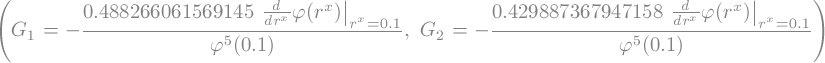

In [43]:
( Eq(G1,sy.N(G1_lambda(rx_=0.1,rdotx_=1,rdotz_=0.1))),
  Eq(G2,sy.N(G2_lambda(rx_=0.1,rdotx_=1,rdotz_=0.1))) )

In [44]:
# G1_eqn

In [45]:
# G2_eqn

### Euler 2-homogeneity of $G$

The geodesic coefficients are apparently positive 2-homogeneous in $\mathbf{v}$. We can check by computing $G_1$ and $G_2$ first for some random-ish values of $\mathbf{v}$, then for suitably scaled values of $\mathbf{v}$ (such as by a factor of $\times \,2.5$), and the comparing the square root ratio of each, which should return that factor.

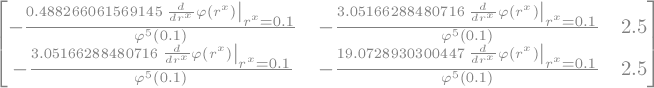

In [46]:
sf = 2.5; rdotx_,rdotz_ = (1,0.1)
G1_1_sf_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_*sf,rdotz_=rdotz_*sf))
G1_1_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_,rdotz_=rdotz_))
sf = 2.5; rdotx_,rdotz_ = (2.5,0.25)
G1_2_sf_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_*sf,rdotz_=rdotz_*sf))
G1_2_ = sy.N(G1_lambda(rx_=0.1,rdotx_=rdotx_,rdotz_=rdotz_))
Matrix([[G1_1_, G1_1_sf_, sqrt(G1_1_sf_/G1_1_)], [G1_2_, G1_2_sf_, 
        sqrt(G1_2_sf_/G1_2_)]])

This is because the Christoffel symbols $\Gamma^i_{jk}$ are 0-homogeneous in ${\mathbf{v}}$, and because:

\begin{equation}
  G^i(\mathbf{\dot{r}}) = \tfrac{1}{2}\Gamma^i_{jk}(\mathbf{r}) {v}^j {v}^k
\end{equation}

which leads to a squared dependence on a scale factor in velocity.

# Misc

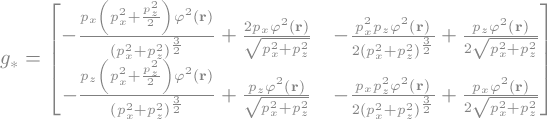

In [47]:
gstar_eqn = gmeq.gstar_varphi_pxpz_eqn.subs({varphi_r:varphi})
gstar_eqn

## Hard-wired

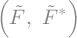

In [48]:
Fvf = symbols(r'\tilde{F}',  real=True, positive=True)
Fvfstar = symbols(r'\tilde{F}^*',  real=True, positive=True)
Fvf, Fvfstar

In [49]:
varphi_ = 1
eta_ = Rational(1,2)

In [50]:
gmeq.Fstar_eqn.subs({varphi_r(rvec):varphi, eta:eta_})

In [51]:
# Fstar4_unity_eqn = Eq( (gmeq.Fstar_eqn.rhs.subs({varphi_r:varphi, eta:eta_}))**4, 1 )
# Fstar4_unity_eqn

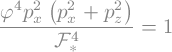

In [52]:
Fstar4_unity_eqn = Eq( 
    (gmeq.Fstar_eqn.rhs.subs({varphi_r(rvec):varphi, eta:eta_})/Fstar)**4, 1 )
Fstar4_unity_eqn

In [53]:
# pz_conj_eqn = Eq(pz, solve(gmeq.rdot_p_unity_eqn,pz)[0])
# pz_conj_eqn

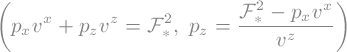

In [54]:
pdotv_Fstar_conj_eqn = Eq(gmeq.rdot_p_unity_eqn.lhs, Fstar**2)
pz_conj_eqn = Eq(pz, solve(pdotv_Fstar_conj_eqn,pz)[0])
pdotv_Fstar_conj_eqn, pz_conj_eqn

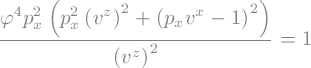

In [55]:
tmp = simplify( Fstar4_unity_eqn.subs(e2d(pz_conj_eqn)).subs({Fstar:1}) )
tmp

In [56]:
px_vx_vz_poly_eqn = Eq( factor((tmp.lhs*denom(tmp.lhs)-tmp.rhs*denom(tmp.lhs)) ), 0)
px_vx_vz_poly_eqn

In [57]:
px_vx_vz_poly_solns = solve( px_vx_vz_poly_eqn, px )
px_vx_vz_eqn = Eq(px, (px_vx_vz_poly_solns[1]))
pz_vx_vz_eqn = pz_conj_eqn.subs(e2d(px_vx_vz_eqn)).subs({Fstar:1})
# px_vx_vz_poly_solns
# px_vx_vz_eqn

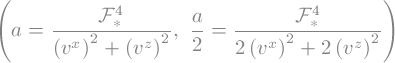

In [58]:
a = symbols(r'a',  real=True, positive=True)
a_subs_eqn = Eq(a, Fstar**4/((rdotx**2+rdotz**2)))
a2_subs_eqn = Eq(a/2, Fstar**4/(2*(rdotx**2+rdotz**2)))
a_subs_eqn, a2_subs_eqn

In [59]:
# (px_vx_vz_poly_solns[1]) 

In [60]:
# px_vx_vz_lambdified = lambdify([varphi,rdotx,rdotz], re(N(px_vx_vz_eqn.rhs)))
# pz_vx_vz_lambdified = lambdify([varphi,rdotx,rdotz], re(N(pz_vx_vz_eqn.rhs)))
# px_vx_vz_lambda = lambda f,vx,vz: float((px_vx_vz_lambdified(f,vx,vz)))
# pz_vx_vz_lambda = lambda f,vx,vz: float((pz_vx_vz_lambdified(f,vx,vz)))
px_vx_vz_lambda \
    = lambda f,vx,vz: float(re(N(px_vx_vz_eqn.rhs.subs({varphi:f,rdotx:vx,rdotz:vz}))))
pz_vx_vz_lambda \
    = lambda f,vx,vz: float(re(N(pz_vx_vz_eqn.rhs.subs({varphi:f,rdotx:vx,rdotz:vz}))))

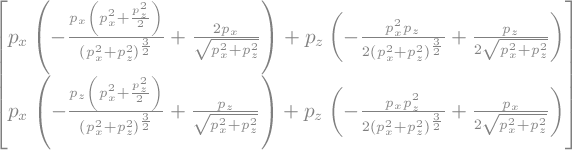

In [61]:
v_from_gstar_lambda_tmp = lambdify((px,pz),
          N(gmeq.gstar_varphi_pxpz_eqn.subs({varphi_r(rvec):varphi_}).rhs*Matrix([px,pz])))
v_from_gstar_lambda = lambda px_,pz_: (v_from_gstar_lambda_tmp(px_,pz_)).flatten()
v_lambda = lambda pa: np.array([(v_from_gstar_lambda(px_,pz_)) for px_,pz_ in pa])
gmeq.gstar_varphi_pxpz_eqn.subs({varphi_r(rvec):varphi_}).rhs*Matrix([px,pz])

In [62]:
vx_, vz_ = 0.9, -0.28
vx_, vz_

In [63]:
px_vx_vz_lambda(1,1,1)

In [64]:
# px_ = px_vx_vz_eqn.rhs.subs({rdotx:vx_,rdotz:vz_}).subs({varphi:varphi_})
# pz_ = pz_vx_vz_eqn.rhs.subs({rdotx:vx_,rdotz:vz_}).subs({varphi:varphi_})
px_ = px_vx_vz_lambda(varphi_,vx_,vz_)
px_

In [65]:
pz_ = pz_vx_vz_lambda(varphi_,vx_,vz_)
pz_

In [66]:
# px_*vx_ + pz_*vz_
Matrix([px_,pz_]).dot(Matrix([vx_,vz_]))

In [67]:
N(gmeq.H_eqn.subs({eta:eta_,varphi_r:varphi_,px:px_,pz:pz_}))

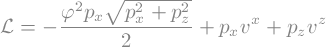

In [68]:
L_prelim_eqn = simplify(Eq(L, px*rdotx + pz*rdotz 
                           - gmeq.H_eqn.rhs.subs({varphi_r(rvec):varphi, eta:eta_})))
L_eqn = (L_prelim_eqn.subs(e2d(px_vx_vz_eqn)).subs(e2d(pz_vx_vz_eqn)))
L_prelim_eqn

In [69]:
# L_lambdified = lambdify([varphi,rdotx,rdotz], ((L_eqn.rhs)))
# L_lambda = lambda f,vx,vz: float(N(re(L_lambdified(f,vx,vz))))
L_lambda = lambda f,vx,vz: float(re(N(L_eqn.rhs.subs({varphi:f,rdotx:vx,rdotz:vz}))))

In [70]:
N(L_eqn.subs({varphi:varphi_,rdotx:rdotx_,rdotz:rdotz_}))
L_lambda(varphi_,rdotx_,rdotz_)

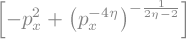

In [71]:
solve(Eq(4*gmeq.H_eqn.rhs**2,1).subs({varphi_r(rvec):varphi_}),pz**2)[:]

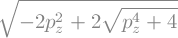

In [72]:
H_parametric_eqn = Eq((2*gmeq.H_eqn.rhs)**2,1).subs({varphi_r(rvec):varphi_, eta:eta_})
px_H_solns = [simplify(sqrt(soln)) for soln in solve( H_parametric_eqn ,px**2)]
pz_H_solns = [simplify(sqrt(soln)).subs({Abs(px):px}) 
              for soln in solve( H_parametric_eqn ,pz**2)]
px_H_soln_ = [soln for soln in px_H_solns if Abs(sy.im(N(soln.subs({pz:1}))))<1e-10][0]
px_H_lambda = lambdify( [pz], simplify(px_H_soln_) )
numer(simplify(px_H_soln_))

In [73]:
pz_min_eqn = Eq(pz_min, 0)
px_min_eqn = Eq(px_min, 
                sqrt(solve(Eq((
                solve(Eq(4*gmeq.H_eqn.rhs**2,1)
                      .subs({varphi_r(rvec):varphi_,eta:eta_}),pz**2)[:])[0],0)
                               ,px**2)[1]))
tanbeta_max_eqn = Eq(tan(beta_max),sy.oo)
tanbeta_max = None
px_min_ = round(float(N(px_min_eqn.rhs.subs({varphi:varphi_}))),4)
pz_min_ = round(float(N(pz_min_eqn.rhs.subs({varphi:varphi_}))),8)
px_min_, -pz_min_, np.rad2deg(np.arctan(px_min_/pz_min_)) if pz_min_>0 else None

(1.0, -0.0, None)

In [74]:
if eta_==Rational(3,2):
    pz_max_ = 10**4
else:
    pz_max_ = 10**2
pz_array = -10**np.linspace(np.log10(pz_min_ if pz_min_>0 else 1e-6), np.log10(pz_max_),1000)
px_array = px_H_lambda(pz_array)
p_array = np.vstack([px_array,pz_array]).T
modp_array = norm(p_array,axis=0)
tanbeta_crit = float(N(gmeq.tanbeta_crit_eqn.rhs.subs({eta:eta_})))
del px_array, pz_array
p_infc_array = p_array[np.abs(p_array[:,0]/p_array[:,1])<tanbeta_crit]
p_supc_array = p_array[np.abs(p_array[:,0]/p_array[:,1])>=tanbeta_crit]

In [75]:
v_infc_array = v_lambda(p_infc_array)
v_supc_array = v_lambda(p_supc_array)
v_array = v_lambda(p_array)

In [76]:
p_vx_vz_lambda = lambda f,v: [px_vx_vz_lambda(f,v[0],v[1]),pz_vx_vz_lambda(f,v[0],v[1])]

In [77]:
p_from_v_array = np.array([p_vx_vz_lambda(varphi_,v_) for v_ in v_array[::1]])
len(p_from_v_array), len(p_array)

In [78]:
p_from_v_infc_array \
    = p_from_v_array[np.abs(p_from_v_array[:,0]/p_from_v_array[:,1])<tanbeta_crit]
p_from_v_supc_array \
    = p_from_v_array[np.abs(p_from_v_array[:,0]/p_from_v_array[:,1])>=tanbeta_crit]

In [79]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.ticker import MaxNLocator

In [80]:
gr = GraphingBase()
job_name = 'demo'

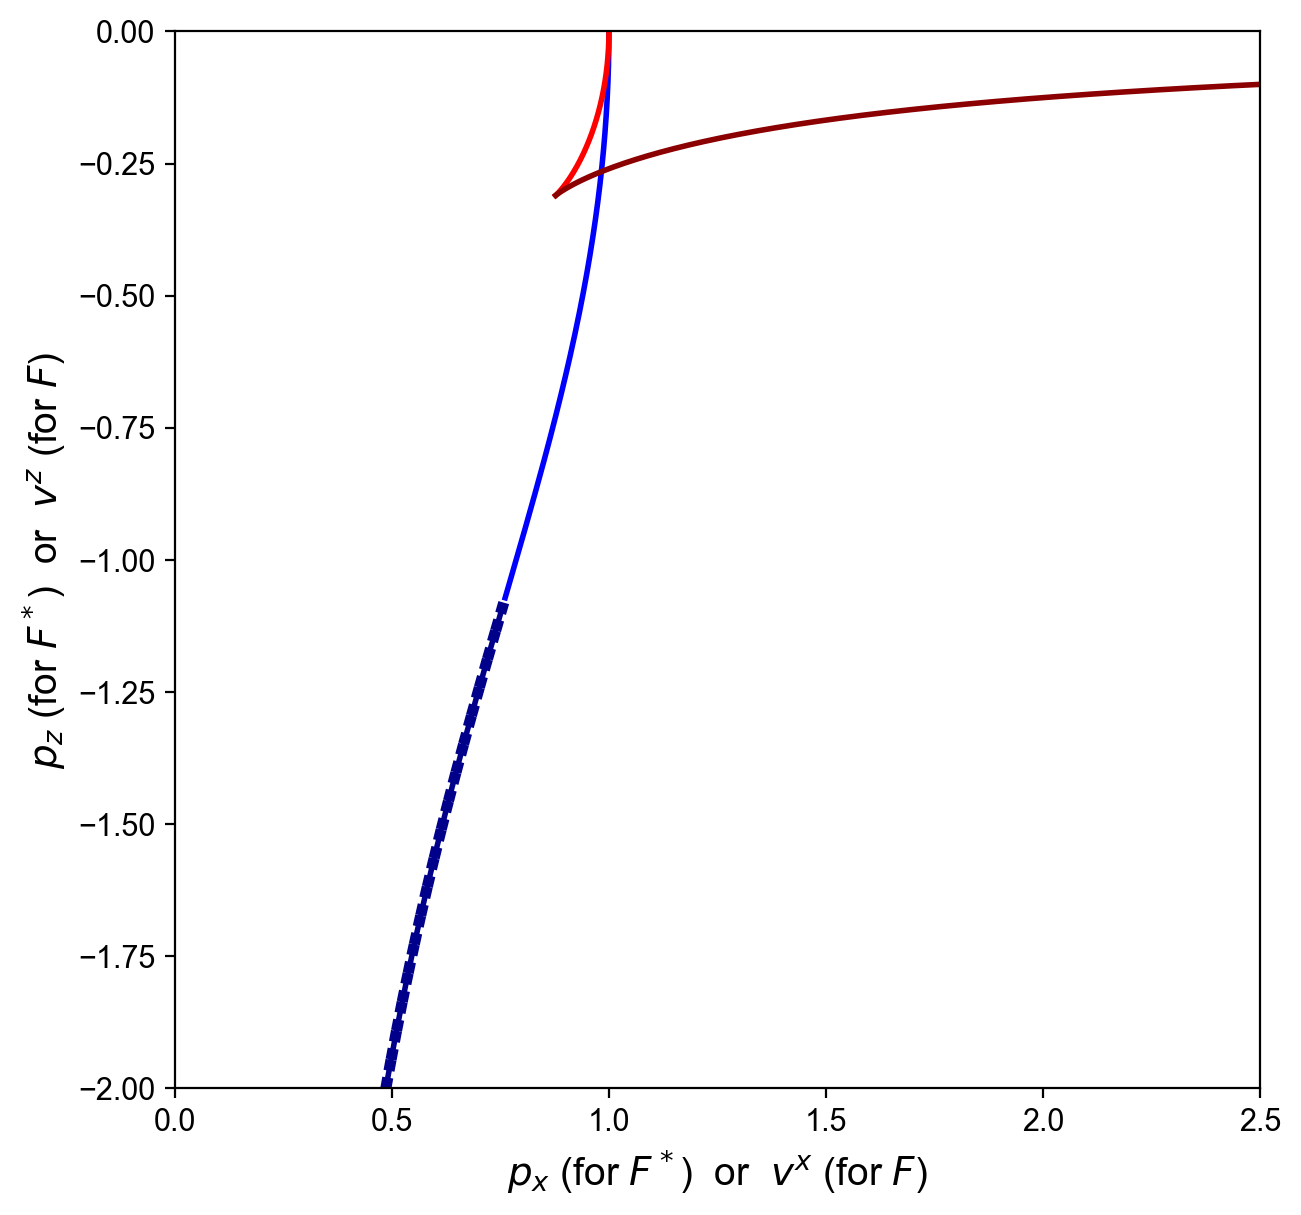

In [81]:
fig = gr.create_figure(job_name+'_Fstar_F_rectlinear', fig_size=(7,7))
plt.plot(p_supc_array[:,0],p_supc_array[:,1], 'Blue', lw=2, ls='-', 
         label=r'$F^*\!\!=1$,  $\beta\geq\beta_\mathrm{c}$')
plt.plot(p_infc_array[:,0],p_infc_array[:,1], 'DarkBlue', lw=2, ls='-', 
         label=r'$F^*\!\!=1$,  $\beta<\beta_\mathrm{c}$')

plt.plot(p_from_v_supc_array[:,0],p_from_v_supc_array[:,1], 'Blue', lw=4, ls='-', 
         label=r'$F^*\!\!=1$,  $\beta\geq\beta_\mathrm{c}$')
plt.plot(p_from_v_infc_array[:,0],p_from_v_infc_array[:,1], 'DarkBlue', lw=4, ls=':', 
         label=r'$F^*\!\!=1$,  $\beta<\beta_\mathrm{c}$')

plt.plot(v_supc_array[:,0],v_supc_array[:,1], 'Red', lw=2, ls='-', 
         label=r'$F=1$,  $\beta\geq\beta_\mathrm{c}$')
# plt.plot([0,vx_abcrit_],[0,vz_abcrit_], 
#          '-.', color='DarkRed', lw=1, label=r'$\alpha_{\mathrm{c}}$')
plt.plot(v_infc_array[:,0],v_infc_array[:,1], 'DarkRed', 
         lw=1 if eta_==Rational(3,2) and not do_zoom else 2, 
         ls='-', 
         label=r'$F=1$,  $\beta<\beta_\mathrm{c}$')
plt.xlabel(r'$p_x$ (for $F^*$)  or  $v^x$ (for $F$)', fontsize=14)
plt.ylabel(r'$p_z$ (for $F^*$)  or  $v^z$ (for $F$)', fontsize=14)
plt.xlim(0,2.5)
plt.ylim(-2,0);

## Hacking

In [82]:
px_test, pz_test = 0.76, -1.07411
N(gmeq.H_eqn.subs({eta:eta_,varphi_r:varphi_,px:px_test,pz:pz_test}))

In [83]:
vz_vx_test_eqn = Eq(rdotz, 
    solve(px_vx_vz_poly_eqn.subs({varphi:varphi_, px:px_test ,pz:pz_test}),rdotz)[0])
vz_vx_test_eqn

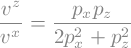

In [84]:
vz_on_vz_eqn = Eq(rdotz/rdotx, px*pz/(2*px**2+pz**2))
vz_on_vz_eqn

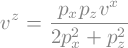

In [85]:
vz_from_tanalpha_eqn = Eq(rdotz, solve(vz_on_vz_eqn,rdotz)[0])
vz_from_tanalpha_eqn

In [86]:
vz_from_tanalpha_test_eqn = vz_from_tanalpha_eqn.subs({px:px_test, pz:pz_test})
vz_from_tanalpha_test_eqn

In [87]:
Eq(vz_from_tanalpha_test_eqn.rhs,vz_vx_test_eqn.rhs)

In [88]:
vx_test = solve(Eq(vz_from_tanalpha_test_eqn.rhs,vz_vx_test_eqn.rhs), rdotx)[0]
vz_test = vz_from_tanalpha_test_eqn.rhs.subs(e2d(vz_from_tanalpha_test_eqn))\
                .subs({rdotx:vx_test})
vx_test, vz_test

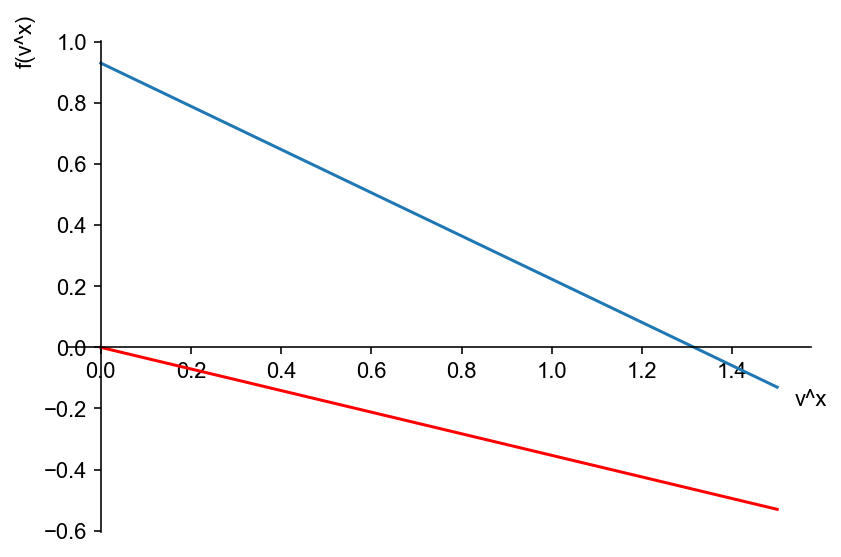

In [89]:
plot_ = sy.plot(vz_vx_test_eqn.rhs, (rdotx,0.00001,1.5), show=False)
plot_.extend(sy.plot(vz_from_tanalpha_test_eqn.rhs, (rdotx,0.00001,1.5), 
                     line_color='red', show=False))
plot_.show()

In [90]:
px_test*vx_test+pz_test*vz_test

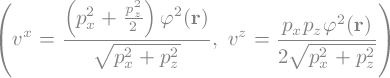

In [91]:
rdotx_eqn = Eq(rdotx, gmeq.rdot_vec_eqn.rhs[0].subs({eta:eta_, varphi_r:varphi}))
rdotz_eqn = Eq(rdotz, gmeq.rdot_vec_eqn.rhs[1].subs({eta:eta_, varphi_r:varphi}))
rdotx_eqn, rdotz_eqn

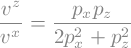

In [92]:
Eq(rdotz/rdotx, simplify((rdotz/rdotx).subs(e2d(rdotz_eqn)).subs(e2d(rdotx_eqn))))

## Smarter

In [93]:
Fstar_eqn = gmeq.Fstar_eqn.subs({varphi_r(rvec):varphi}).subs({eta:Rational(1,2)})
Fstar_eqn

In [94]:
Fstar_pow4_eqn = Eq(Fstar_eqn.lhs**4, Fstar_eqn.rhs**4)
Fstar_pow4_eqn

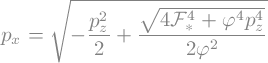

In [95]:
px_Fstar_pow4_eqn = Eq(px, sqrt(solve(Fstar_pow4_eqn,px**2)[1]))
px_Fstar_pow4_eqn

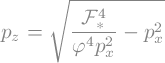

In [96]:
pz_Fstar_pow4_eqn = Eq(pz, sqrt(solve(Fstar_pow4_eqn,pz**2)[0]))
pz_Fstar_pow4_eqn

In [97]:
gmeq.rdot_p_unity_eqn

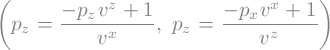

In [98]:
px_conj_eqn = Eq(pz, solve(gmeq.rdot_p_unity_eqn,px)[0])
pz_conj_eqn = Eq(pz, solve(gmeq.rdot_p_unity_eqn,pz)[0])
px_conj_eqn, pz_conj_eqn

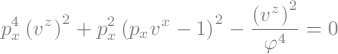

In [99]:
# px_combo_eqn = Eq(pz_conj_eqn.rhs, pz_Fstar_pow4_eqn.rhs)
px_combo_eqn = simplify( Eq(pz_conj_eqn.rhs**2*rdotz**2*px**2
                            - pz_Fstar_pow4_eqn.rhs**2*rdotz**2*px**2, 0) ).subs({Fstar:1})
px_combo_eqn

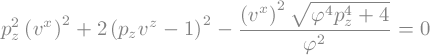

In [100]:
# pz_combo_eqn = Eq(px_conj_eqn.rhs, px_Fstar_pow4_eqn.rhs)
pz_combo_eqn = simplify( Eq(px_conj_eqn.rhs**2*rdotx**2*2
                            - px_Fstar_pow4_eqn.rhs**2*rdotx**2*2, 0) ).subs({Fstar:1})
pz_combo_eqn

In [101]:
# solve(pz_combo_eqn,pz)

In [102]:
solns = solve(px_vx_vz_poly_eqn,px)
len(solns)

In [103]:
px_vx_vz_eqn = Eq(px, [factor(soln.args[1].args[0]) for soln in solns 
                 if Abs(im(soln.subs({rdotx:1,rdotz:-0.0001,varphi:10})))<1e-10
                 and Abs(re(soln.subs({rdotx:1,rdotz:-0.0001,varphi:10})))>0.1][0])
# px_vx_vz_eqn = Eq(px, factor(solns[3].args[1].args[0]))
# px_vx_vz_eqn

pz_vx_vz_eqn = Eq(pz, 
                  factor(solve(gmeq.rdot_p_unity_eqn,pz)[0])
                      .subs(e2d(px_vx_vz_eqn))
                      .subs({Fstar:1}))
# pz_vx_vz_eqn

IndexError: list index out of range

In [ ]:
vx_,vz_ = 0.9,-0.28
vx_, vz_ = 0.789611273906852, -0.372306209952674
px_ = N( px_vx_vz_eqn.rhs.subs({rdotx:vx_, rdotz:vz_, varphi:varphi_}) )
pz_ = N( pz_vx_vz_eqn.rhs.subs({rdotx:vz_, rdotz:vz_, varphi:varphi_}) )
px_, pz_

In [ ]:
px_*vx_+pz_*vz_

In [ ]:
gmeq.rdot_p_unity_eqn.lhs, \
gmeq.rdot_p_unity_eqn.lhs.subs({rdotx:vx_, rdotz:vz_, varphi:varphi_}).subs({px:px_, pz:pz_})

In [ ]:
N(gmeq.H_eqn.subs({eta:Rational(1,2),varphi_r:varphi_,px:px_,pz:pz_}))

$
    H := \dfrac{\varphi^2(r^x) \,p_x^{2\eta}}{2\left(p_x^2+p_z^2\right)^{\eta-1}}
$